# Text Generation with gpt-neo
author: Mengliu Zhao\
date: Aug 5, 2024

This notebook is a demo on finetuning EleutherAI's gpt-neo-1.3B model for text generation purposes:
* gpt-neo-1.3B: https://huggingface.co/EleutherAI/gpt-neo-1.3B
* dataset source: https://www.kaggle.com/datasets/adammcmurchie/news-headlines-summary-from-select-12-sources
* hardward: single A-100 GPU
* python version: 3.10.2

Install requirements:\
`pip install -r requirements.txt`

The trained model weights can be downloaded from [here](https://drive.google.com/drive/folders/1--dJ-7tcugnPoN5KallktRsQ7P_Sx63L?usp=sharing). To use it, simply put the downloaded "checkpoint-10000" folder under "model_weights" directory.



## 1. Dataset EDA
The News Headlines & Summary dataset only contains one csv file. We randomly split 5% rows for testing purposes and use the rest for training purposes.

We'll run a statistical analysis of the sequence length and set the max_len=64 for the tokenizer.


In [3]:
import pandas as pd

df = pd.read_csv("./data/full_data.csv")

print(df[:10])

  Unnamed: 0    source    author  \
0          0  BBC News  BBC News   
1          0  BBC News  BBC News   
2          0  BBC News  BBC News   
3          0  BBC News  BBC News   
4          0  BBC News  BBC News   
5          0  BBC News  BBC News   
6          0  BBC News  BBC News   
7          0  BBC News  BBC News   
8          0  BBC News  BBC News   
9          0  BBC News  BBC News   

                                               title  \
0  Coronavirus fears see South by Southwest cance...   
1  Woody Allen book pulped after walkout at publi...   
2  Blind man denied US citizenship over Braille test   
3  Clinton claims Lewinsky affair 'managed anxiet...   
4          Teen abducted 'over brother's drugs debt'   
5     Why the wait for a female US president goes on   
6        Top Afghan officials escape deadly shooting   
7       Young chess players 'killed by laughing gas'   
8   Coronavirus: China announces more imported cases   
9    'The positive things we learnt from qu

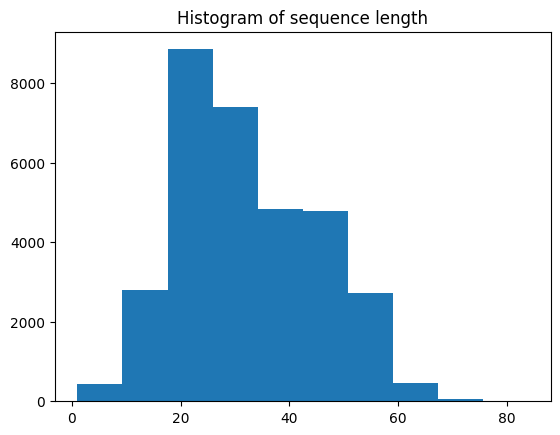

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer.pad_token = tokenizer.eos_token

seq_len = []
for desc in df["description"].tolist():
    if desc is not None and isinstance(desc, str):
        input = tokenizer(desc)
        seq_len.append(len(input["input_ids"]))

plt.figure()
plt.title("Histogram of sequence length")
_ = hist(seq_len, 10)

## 2. Pre-process Dataset

We use Huggingface's datasets library to build the training and testing set.

Make sure leave the downloaded csv file under the "data" folder and don't place any other csv file there as load_dataset will automatically read every csv file under the given folder.

In [5]:
from datasets import load_dataset

dataset_train, dataset_test = load_dataset("data", split=['train[:95%]', 'train[95%:]'])

Generating train split: 35207 examples [00:00, 94897.56 examples/s]


In [6]:
print(dataset_train)
print(dataset_test)

Dataset({
    features: ['Unnamed: 0', 'source', 'author', 'title', 'description', 'url', 'requested_date', 'publishedAt', 'content'],
    num_rows: 33447
})
Dataset({
    features: ['Unnamed: 0', 'source', 'author', 'title', 'description', 'url', 'requested_date', 'publishedAt', 'content'],
    num_rows: 1760
})


In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer.pad_token = tokenizer.eos_token

max_len = 64
def tokenize_function(examples):
    inputs = {"input_ids": [], "attention_mask": [], "token_type_ids": [], "labels": []}
    for title, desc in zip(examples["title"], examples["description"]):
        if title is not None and desc is not None:
            tokenized_item = tokenizer.encode_plus(title,
                                                   add_special_tokens=True,
                                                    max_length=max_len,
                                                    return_token_type_ids=True,
                                                    truncation=True,
                                                    padding="max_length",
                                                    )
            
            tokenized_label = tokenizer.encode_plus(desc, 
                                                    add_special_tokens=True,
                                                    max_length=max_len,
                                                    return_token_type_ids=True,
                                                    truncation=True,
                                                    padding="max_length",
                                                    )
            
            inputs["input_ids"].append(tokenized_item["input_ids"])
            inputs["attention_mask"].append(tokenized_item["attention_mask"])
            inputs["token_type_ids"].append(tokenized_item["token_type_ids"])
            inputs["labels"].append(tokenized_label["input_ids"])
    return inputs

tokenized_train = dataset_train.map(
    tokenize_function,
    batched=True,
    batch_size=10,
    remove_columns=dataset_train.column_names,
)

tokenized_test = dataset_test.map(
    tokenize_function,
    batched=True,
    batch_size=10,
    remove_columns=dataset_test.column_names,
)

Map: 100%|██████████| 1760/1760 [00:00<00:00, 2375.18 examples/s]


## 3. Model Training
We use the Trainer to finetune the GPT model.

In [ ]:
from transformers import (AutoModelForCausalLM, 
                          TrainingArguments, 
                          Trainer,
                          DataCollatorForLanguageModeling,
                          AutoTokenizer,
)

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer.pad_token = tokenizer.eos_token

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")

training_args = TrainingArguments(
    output_dir="model_weights",
    eval_strategy="steps",
    eval_steps=1000,
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False,
    fp16=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=1,
    max_steps=10000,
    save_strategy="steps",
    save_steps=10000,
    fp16_opt_level="O3",
    save_only_model=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
)

trainer.train()

In [ ]:
from transformers import pipeline, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("model_weights/checkpoint-10000")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer.pad_token = tokenizer.eos_token

generator = pipeline("text-generation", model=model, tokenizer=tokenizer, max_length=64)

titles = dataset_test["title"]
descs = dataset_test["description"]

for t, d in zip(titles[:4], descs[:4]):
    print("="*20)
    print("Title", t)
    print("Description", d)
    print("Generated", generator(t))